# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import pandas as pd
import random as rn
import os
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [2]:
from keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print('Tensorflow version: ',tf.__version__)
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Tensorflow version:  2.3.0
Please install GPU version of TF


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size

In [4]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
print('# training batches =', int(num_train_sequences/30))
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# training batches = 22
# validation sequences = 100
# epochs = 50


As we can see we have two shapes of images (160,120) and (360,360).  We will standardize the image shapes to (120,120)

## Model

### Transfer Learning using MobileNetV2

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras import initializers

#write your model here
nb_filters = [8,16,32,64]
nb_dense = [1024, 512, 5]

pre_trained_model = VGG16(weights='imagenet',input_shape = (160, 160, 3), include_top=False)

for layer in pre_trained_model.layers:
    layer.trainable = False

# Last layer output of pre-trained model
last_output = pre_trained_model.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(nb_dense[0], activation='relu')(x)
x = layers.Dense(nb_dense[1], activation='relu')(x) 

# Add a dropout rate of 0.4
x = layers.Dropout(0.4)(x) 

# Add a final sigmoid layer for classification
x = layers.Dense  (nb_dense[2], activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

58892288/58889256 [==============================] - 30s 1us/step


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [6]:
optimiser = optimizers.Adam(lr=0.01)  #write your optimizer
cb = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

mc = ModelCheckpoint('nats_best_model.h5', monitor='val_loss', mode='min', 
                     save_best_only=True, save_weights_only=False)

LR =  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min',
                        min_delta=0.0001, cooldown=0, min_lr=0) 


callbacks_list=[cb, mc, LR]
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy']) 
print (model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [7]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   #width_shift_range = 0.2,
                                   #height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   #zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1./255.)

# Flow training images in batches of batch_size using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_path,
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical', 
                                                    target_size = (160, 160))     

# Flow validation images in batches of batch_size using test_datagen generator
val_generator =  test_datagen.flow_from_directory(val_path,
                                                  batch_size  = batch_size,
                                                  class_mode  = 'categorical', 
                                                  target_size = (160, 160))

Found 19909 images belonging to 5 classes.
Found 3000 images belonging to 5 classes.


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [8]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [9]:
history = model.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = 30,
            validation_steps = validation_steps,
            callbacks=callbacks_list,
            verbose = 1)

Epoch 1/30
23/23 [==============================] - 167s 7s/step - loss: 3.3796 - categorical_accuracy: 0.2333 - val_loss: 1.3072 - val_categorical_accuracy: 0.4417
Epoch 2/30
23/23 [==============================] - 167s 7s/step - loss: 1.4119 - categorical_accuracy: 0.4087 - val_loss: 1.2106 - val_categorical_accuracy: 0.4667
Epoch 3/30
23/23 [==============================] - 159s 7s/step - loss: 1.2327 - categorical_accuracy: 0.4841 - val_loss: 1.0450 - val_categorical_accuracy: 0.6000
Epoch 4/30
23/23 [==============================] - 149s 6s/step - loss: 1.0864 - categorical_accuracy: 0.5609 - val_loss: 0.9363 - val_categorical_accuracy: 0.6667
Epoch 5/30
23/23 [==============================] - 140s 6s/step - loss: 0.8986 - categorical_accuracy: 0.6551 - val_loss: 0.8150 - val_categorical_accuracy: 0.6333
Epoch 6/30
23/23 [==============================] - 141s 6s/step - loss: 0.7621 - categorical_accuracy: 0.7087 - val_loss: 0.8062 - val_categorical_accuracy: 0.6917
Epoch 7/30

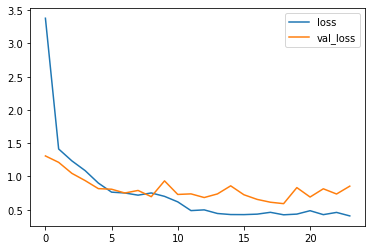

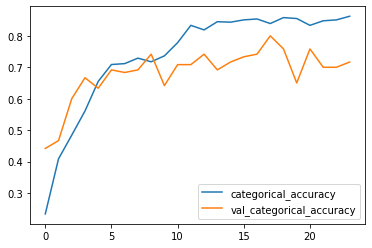

In [10]:
# Plot Train and validation loss and accuracies
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();

#### We have seen 80% validation accuracy and a high train accuracy of around 86%.  Model's performance is satisfactory but still opportunities to improve.  